# Generate "clean" reference dataset

In this notebook, we'll read the assembled PBMC reference dataset and remove cell types flagged as Doublets, Contamination, or with high mitochondrial content. We'll then re-project the clean reference for use in visualization and for construction of reference models.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

## Read annotated dataset

In [4]:
h5ad_uuid = '157bd496-0f1e-4239-83bc-a9616696b63a'

In [5]:
adata = read_adata_uuid(h5ad_uuid)

In [6]:
adata.shape

(1952128, 1236)

## Filter cell types

In [7]:
exclude_terms = [
    'Contamination', 'contamination',
    'Doublet', 'doublet',
    'Mito', 'mito'
]

In [8]:
all_types = adata.obs['AIFI_L3'].unique().tolist()

In [9]:
exclude_types = []
for cell_type in all_types:
    for term in exclude_terms:
        if term in cell_type:
            exclude_types.append(cell_type)

In [10]:
exclude_types

['Contamination',
 'Naive CD8 T cell Platelet Doublets',
 'T_B doublet',
 'C5_C12_Contamination',
 'Doublet',
 'T+Erythocytes doublet',
 'NK+T Doublets',
 'Monocytes+Erythocytes doublet',
 'Proliferating Cells+Monocytes Doublets',
 'NK_Mono doublet',
 'B_mono doublet',
 'B_platelet doublet',
 'CD4 naive Platelet Doublets',
 'Erythrocyte contamination',
 'CD4 naive CD16 Monocytes Doublets',
 'CD56dim Mito+ NK',
 'NK+Platelet Doublet',
 'B+Erythocytes doublet',
 'NK+Erythocytes Doublet',
 'NK+Erythocytes doublet']

In [11]:
keep_types = []
for cell_type in all_types:
    if not cell_type in exclude_types:
        keep_types.append(cell_type)

## How many are excluded?

In [12]:
all_counts = adata.obs['AIFI_L3'].value_counts()
n_all = sum(all_counts)
n_all

1952128

In [13]:
exclude_counts = all_counts[exclude_types]

In [14]:
exclude_counts

AIFI_L3
Contamination                             10233
Naive CD8 T cell Platelet Doublets        14199
T_B doublet                                2803
C5_C12_Contamination                       1937
Doublet                                   46150
T+Erythocytes doublet                      9148
NK+T Doublets                              5494
Monocytes+Erythocytes doublet              2491
Proliferating Cells+Monocytes Doublets      122
NK_Mono doublet                            2114
B_mono doublet                             2535
B_platelet doublet                         3948
CD4 naive Platelet Doublets                5769
Erythrocyte contamination                  5962
CD4 naive CD16 Monocytes Doublets          1367
CD56dim Mito+ NK                           2768
NK+Platelet Doublet                        4214
B+Erythocytes doublet                       953
NK+Erythocytes Doublet                     5181
NK+Erythocytes doublet                     1074
Name: count, dtype: int64

In [15]:
n_exclude = sum(exclude_counts)
n_exclude

128462

Percent removed:

In [16]:
n_exclude / n_all * 100

6.58061356632352

## Generate filtered object

In [17]:
adata.obs['keep'] = adata.obs['AIFI_L3'].isin(keep_types).astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


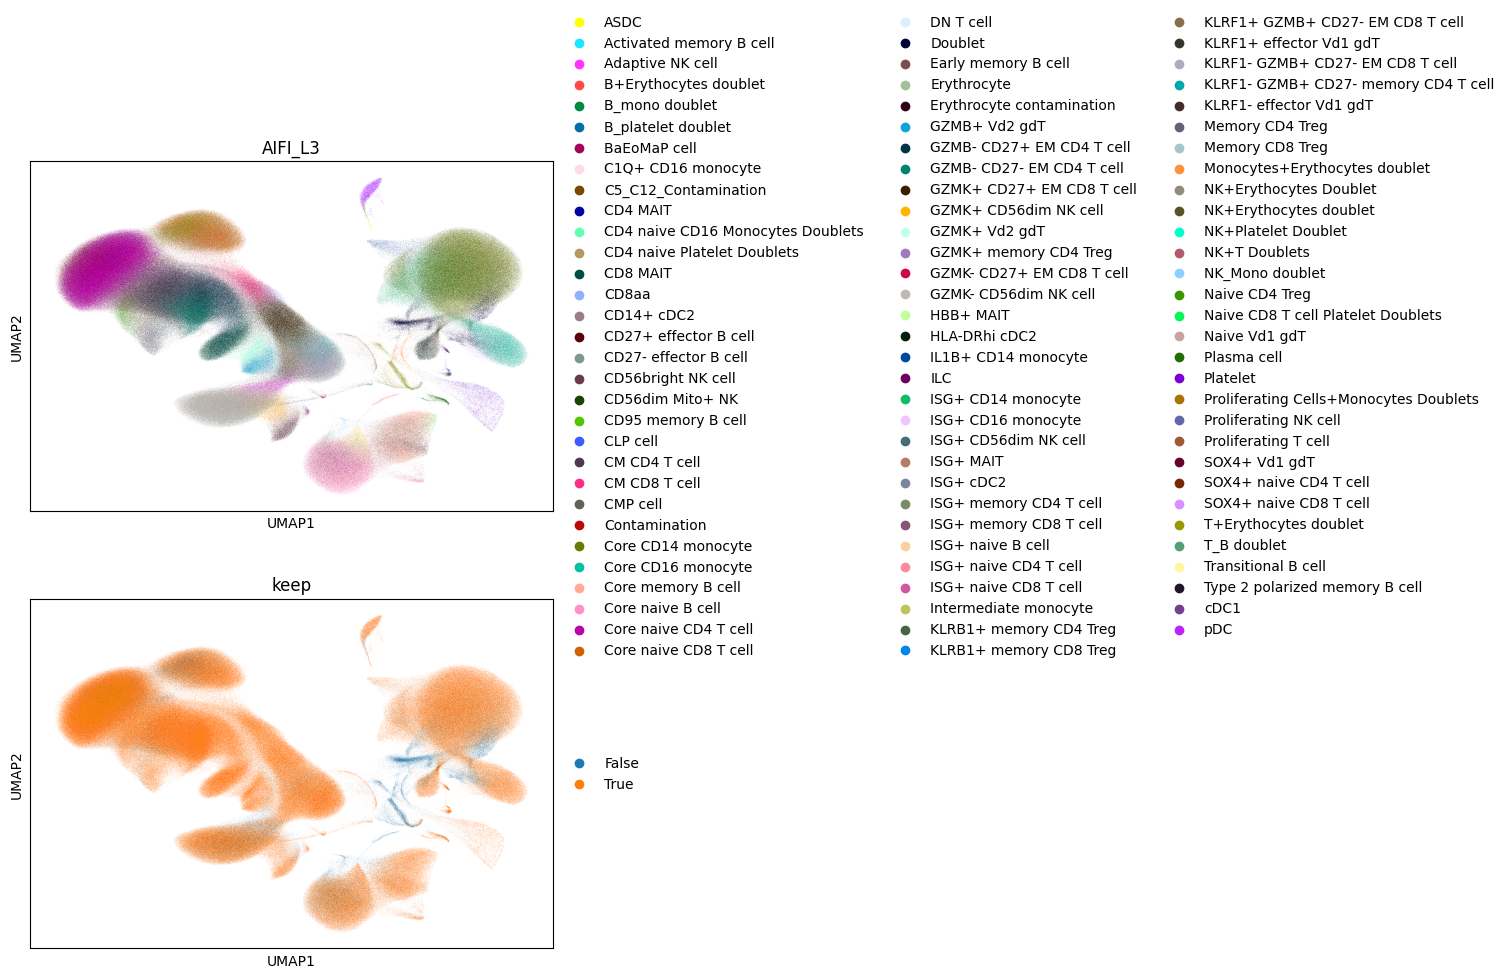

In [18]:
sc.pl.umap(
    adata,
    color = ['AIFI_L3', 'keep'],
    ncols = 1
)

In [19]:
adata_subset = adata[adata.obs['AIFI_L3'].isin(keep_types)]
adata_subset.shape

(1823666, 1236)

In [20]:
obs = adata_subset.obs.copy()
obs['AIFI_L1'] = obs['AIFI_L1'].cat.remove_unused_categories()
obs['AIFI_L2'] = obs['AIFI_L2'].cat.remove_unused_categories()
obs['AIFI_L3'] = obs['AIFI_L3'].cat.remove_unused_categories()
adata_subset.obs = obs

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


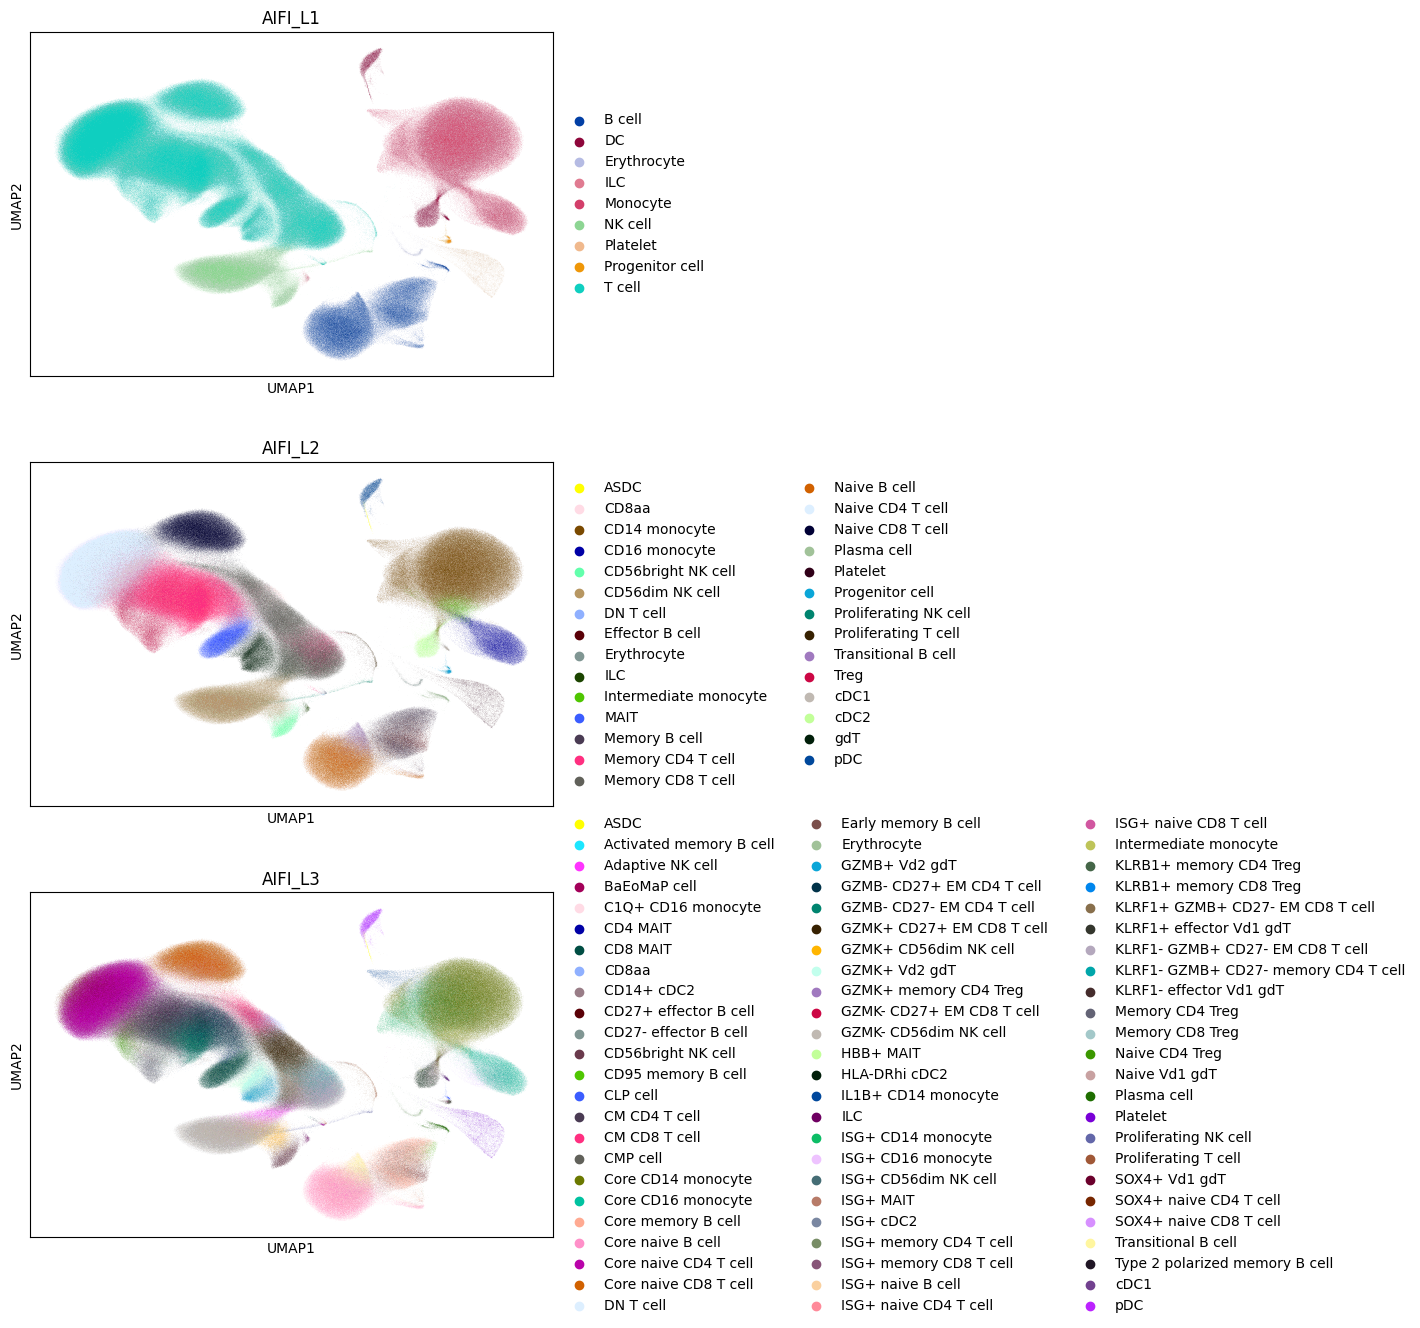

In [21]:
sc.pl.umap(
    adata_subset,
    color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'],
    ncols = 1
)

## Re-project with the cleaned up data only

Now that we've removed the doublets and contamination, we'll redo variable feature selection and generate an updated UMAP projection.

In [22]:
adata_subset = adata_subset.raw.to_adata()

In [23]:
adata_subset.raw = adata_subset

In [24]:
sc.pp.normalize_total(adata_subset, target_sum = 1e4)

In [25]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)

In [26]:
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]].copy()

In [27]:
sc.pp.scale(adata_subset)

In [28]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [29]:
harmony_h5ad = 'output/harmony.h5ad'
neighbors_h5ad = 'output/neighbors.h5ad'
umap_h5ad = 'output/umap.h5ad'

In [30]:
if os.path.exists(umap_h5ad):
    print('Skipping harmony - later step complete')
elif os.path.exists(neighbors_h5ad):
    print('Skipping harmony - later step complete')
elif os.path.exists(harmony_h5ad):
    print('Loading harmony - previously computed')
    adata_subset = scanpy.read_h5ad(harmony_h5ad)
else:
    sce.pp.harmony_integrate(
        adata_subset, 
        'cohort.cohortGuid',
        max_iter_harmony = 30)
    adata_subset.write_h5ad(harmony_h5ad)

Skipping harmony - later step complete


In [31]:
if os.path.exists(umap_h5ad):
    print('Skipping neighbors - later step complete')
elif os.path.exists(neighbors_h5ad):
    print('Loading neighbors - previously computed')
    adata_subset = sc.read_h5ad(neighbors_h5ad)
else:   
    sc.pp.neighbors(
        adata_subset, 
        n_neighbors = 50,
        use_rep = 'X_pca_harmony', 
        n_pcs = 30)
    adata_subset.write_h5ad(neighbors_h5ad)

Skipping neighbors - later step complete


In [32]:
if os.path.exists(umap_h5ad):
     adata_subset = sc.read_h5ad(umap_h5ad)
else:  
    sc.tl.umap(adata_subset, min_dist = 0.05)
    adata_subset.write_h5ad(umap_h5ad)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


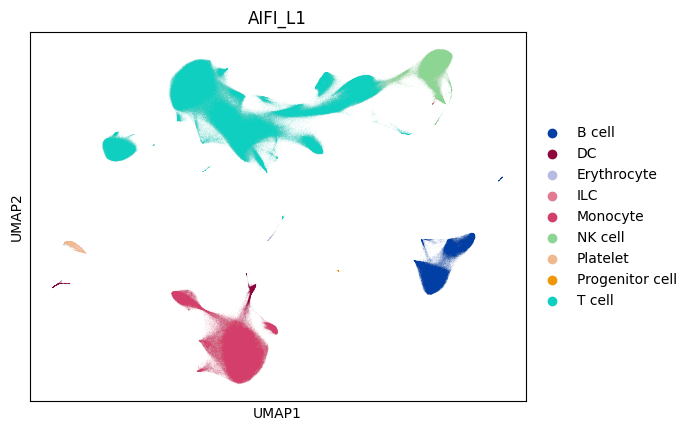

In [33]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L1'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


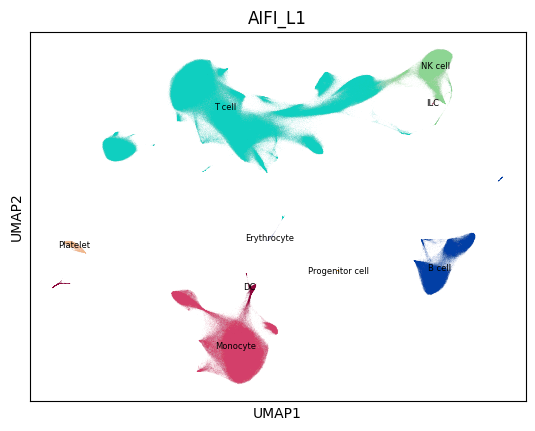

In [34]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L1',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


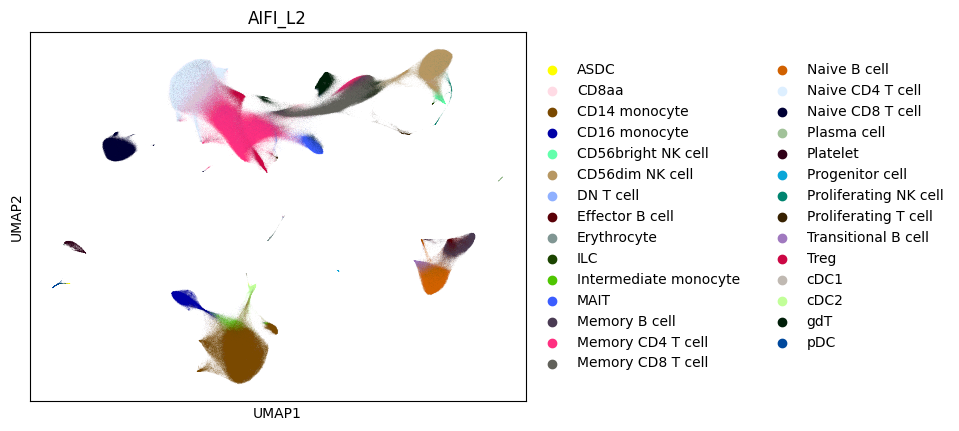

In [35]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


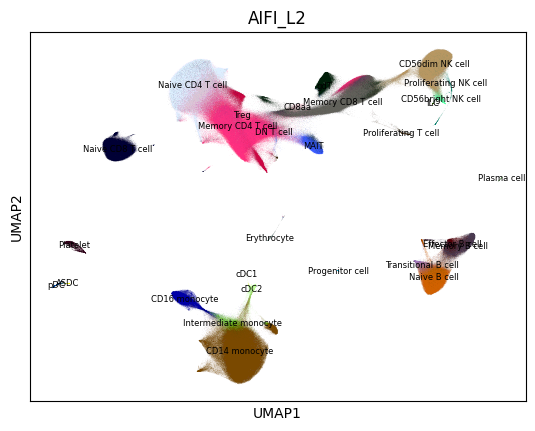

In [36]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


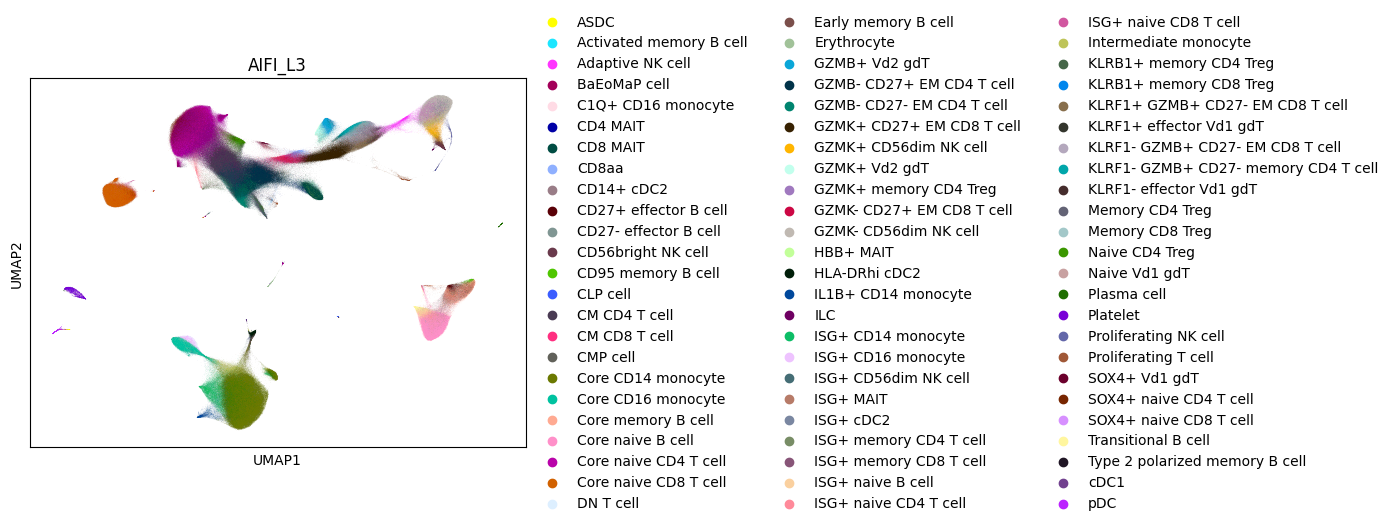

In [37]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


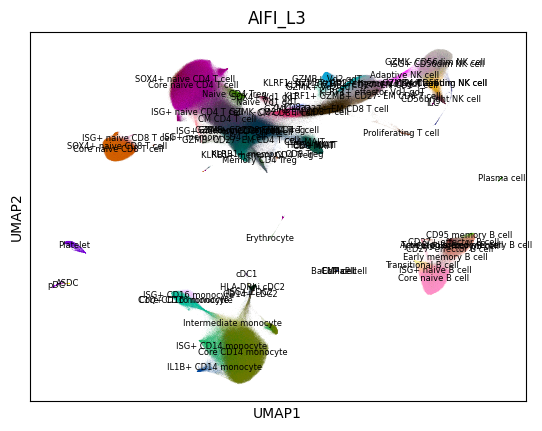

In [38]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

## Output final annotations

In [39]:
obs = adata_subset.obs
obs = obs.reset_index(drop = True)

In [40]:
umap_mat = adata_subset.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [41]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden,AIFI_L1,AIFI_L2,AIFI_L3,keep,umap_1,umap_2
0,cf71f47048b611ea8957bafe6d70929e,B001,weathered_pernicious_polliwog,cf71f47048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1081,115,9307,...,115,4.753590,4.032258,13,T cell,MAIT,CD8 MAIT,True,4.463898,8.976911
1,cf71f54248b611ea8957bafe6d70929e,B001,untidy_emulsive_hamadryad,cf71f54248b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1923,178,22729,...,178,5.187386,2.731737,2,T cell,Naive CD4 T cell,Core naive CD4 T cell,True,-1.846415,11.330785
2,cf71fa1048b611ea8957bafe6d70929e,B001,impatient_familial_cuckoo,cf71fa1048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,204,11107,...,204,5.323010,5.935409,3,Monocyte,CD14 monocyte,Core CD14 monocyte,True,0.942636,-3.349790
3,cf71fb7848b611ea8957bafe6d70929e,B001,long_weakminded_roebuck,cf71fb7848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1118,77,12990,...,77,4.356709,2.071006,1,T cell,Memory CD4 T cell,CM CD4 T cell,True,0.040117,10.309824
4,cf71ffba48b611ea8957bafe6d70929e,B001,dastardly_wintery_airedale,cf71ffba48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1965,363,15979,...,363,5.897154,6.871096,9,Monocyte,CD14 monocyte,Core CD14 monocyte,True,0.164634,-5.827641


In [42]:
obs_out_csv = '{p}/ref_clean_pbmc_labeled_meta_umap_{d}.csv'.format(p = out_dir, d = date.today())
obs.to_csv(obs_out_csv, index = False)

In [43]:
obs_out_parquet = '{p}/ref_clean_pbmc_labeled_meta_umap_{d}.parquet'.format(p = out_dir, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [44]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [45]:
label_out_csv = '{p}/ref_clean_pbmc_barcode_labels_{d}.csv'.format(p = out_dir, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [46]:
label_out_parquet = '{p}/ref_clean_pbmc_barcode_labels_{d}.parquet'.format(p = out_dir, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Output labeled AnnData

In [47]:
out_h5ad = '{p}/ref_clean_pbmc_labeled_{d}.h5ad'.format(p = out_dir, d = date.today())
adata_subset.write_h5ad(out_h5ad)

## Upload results to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [48]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = '10x 3-prime PBMC Clean Reference {d}'.format(d = date.today())

In [49]:
in_files = [h5ad_uuid]

In [50]:
in_files

['157bd496-0f1e-4239-83bc-a9616696b63a']

In [51]:
out_files = [out_h5ad,
             obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [52]:
out_files

['output/ref_clean_pbmc_labeled_2024-03-09.h5ad',
 'output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.csv',
 'output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.parquet',
 'output/ref_clean_pbmc_barcode_labels_2024-03-09.csv',
 'output/ref_clean_pbmc_barcode_labels_2024-03-09.parquet']

In [53]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_clean_pbmc_labeled_2024-03-09.h5ad
output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.csv
output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.parquet
output/ref_clean_pbmc_barcode_labels_2024-03-09.csv
output/ref_clean_pbmc_barcode_labels_2024-03-09.parquet
you are trying to upload file_ids... ['output/ref_clean_pbmc_labeled_2024-03-09.h5ad', 'output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.csv', 'output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.parquet', 'output/ref_clean_pbmc_barcode_labels_2024-03-09.csv', 'output/ref_clean_pbmc_barcode_labels_2024-03-09.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': '00c2c69f-fc9d-4af0-a777-06e8241a9be4',
 'files': ['output/ref_clean_pbmc_labeled_2024-03-09.h5ad',
  'output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.csv',
  'output/ref_clean_pbmc_labeled_meta_umap_2024-03-09.parquet',
  'output/ref_clean_pbmc_barcode_labels_2024-03-09.csv',
  'output/ref_clean_pbmc_barcode_labels_2024-03-09.parquet']}

In [54]:
import session_info
session_info.show()